In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/home/dana_z/ssd_2TB/6OHDA')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package

In [3]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5','FinalData_6OHDA_H_skip.h5','FinalData_6OHDA_skip.h5']

<b> check that spike detection works properly and save it </b>

In [4]:
miceList = getMiceList(Files[0])

<b> get trace and speed data by cell type and Parkinsons/Helathy </b>

In [5]:
# data for all mice - no filter
PVdataH = getData(Files[0],['speed','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x==0)
PVdataP = getData(Files[0],['speed','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x>0)
MSNdataH = getData(Files[0],['speed','trace'],period ='Pre',red = False,day = lambda x: x==0)
MSNdataP = getData(Files[0],['speed','trace'],period ='Pre',red = False,day = lambda x: x>0)
CHIdataH = getData(Files[0],['speed','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)
CHIdataP = getData(Files[0],['speed','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x>0)

# data for all mice - homomorphic filter
HfPVdataH = getData(Files[1],['speed','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x==0)
HfPVdataP = getData(Files[1],['speed','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x>0)
HfMSNdataH = getData(Files[1],['speed','trace'],period ='Pre',red = False,day = lambda x: x==0)
HfMSNdataP = getData(Files[1],['speed','trace'],period ='Pre',red = False,day = lambda x: x>0)
HfCHIdataH = getData(Files[1],['speed','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)
HfCHIdataP = getData(Files[1],['speed','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x>0)

# data for Beta Mice - NOTICE: ONLY 1222 is CHI rest are PV
betaMice = ['8430','4539','7584','7909','1222']

/home/dana_z/ssd_2TB/6OHDA/IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value


cleaning up trace data
I deleted session: 7584_day0
I deleted session: 8430_BaselineA
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1236_day19L
I deleted session: 4539_day11
I deleted session: 4539_day5
I deleted session: 7909_day30A
I deleted session: 8430_day1
I deleted session: 8430_day15A
I deleted session: 8430_day9
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day30A
I deleted session: 8803_day5
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1253_BaselineA
I deleted session: 1253_BaselineS
I deleted session: 1793_BaselineA
I deleted session: 8815_BaselineL
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 0761_day1
I deleted session: 0761_day12
I deleted session: 076

<b> repeat figure 2a </b> event shape per cell

In [6]:
#TODO later if feel like

<b> recreate figure 2b - event rate per cell type All, low mvmt, high mvmt </b>

In [6]:
#f = h5py.File('OnsetsAndPeriods.hdf5','r')
col_names = ['Mouse','Sess','Day','start_high','start_med','start_low','All_','end_high','end_med','end_low','acc','dcc']
df = pd.DataFrame(columns = col_names)
cond = ['PVdataH','MSNdataH','CHIdataH','PVdataP','MSNdataP','CHIdataP']
transWindow = np.ones((10,1))
for c in cond:
    data = eval(c)
    for sess in data.keys():
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            m = sess[0:4]

            Hp = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            Mp = ((Hp+Lp)==0)
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
            CaO = Ca[:,1:]-Ca[:,:-1]
            if CaO.shape[1]<Hp.shape[0]:
                 CaO = np.append(CaO,np.zeros((CaO.shape[0],1)),axis=1)
            C_start = (CaO==1)*1
            C_end = (CaO==-1)*1
#            Acc = np.append(np.convolve(np.diff(Lp*1+Mp*2+Hp*3)>0, transWindow[:,0], mode='same')>0,False)
#            Dcc = np.append(np.convolve(np.diff(Lp*1+Mp*2+Hp*3)<0, transWindow[:,0], mode='same')>0,False)
            Acc = np.append(np.convolve(np.diff(Lp*1+Hp*2)>0, transWindow[:,0], mode='same')>0,False)
            Dcc = np.append(np.convolve(np.diff(Lp*1+Hp*2)<0, transWindow[:,0], mode='same')>0,False)
            a = np.asarray([np.sum(C_start[:,Hp],axis=1),np.sum(C_start[:,Mp],axis=1),
                            np.sum(C_start[:,Lp],axis=1),np.sum(C_start,axis=1),
                            np.sum(C_end[:,Hp],axis=1),np.sum(C_end[:,Mp],axis=1),np.sum(C_end[:,Lp],axis=1),
                            np.sum(C_end[:,Acc],axis=1),np.sum(C_end[:,Dcc],axis=1)]).T
            df2 = pd.DataFrame(a, columns = col_names[3:])
            df2['totalTime'] = (Hp.shape[0]/1200)
            df2['lowTime'] = np.sum(Lp/1200)
            df2['medTime'] = np.sum(Mp/1200)
            df2['highTime'] = np.sum(Hp/1200)
#            df2['accTrans'] = np.sum(np.diff(Lp*1+Mp*2+Hp*3)>0)
#            df2['dccTrans'] = np.sum(np.diff(Lp*1+Mp*2+Hp*3)<0)
            df2['accTrans'] = np.sum(np.diff(Lp*1+Hp*2)>0)
            df2['dccTrans'] = np.sum(np.diff(Lp*1+Hp*2)<0)
            df2['Day'] = day
            df2['Mouse'] = m
            df2['Sess'] = sess
            df2['CellType'] = c[:-5]
            df = pd.concat([df,df2],sort=True)
        except:
            print(sess)



/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


In [7]:
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<5:
        return 'Day 1-4'
    elif day<13:
        return 'Day 5-12'
    elif day<21:
        return 'Day 13-20'
    else:
        return 'One Month'
df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)
df['Beta'] = df.apply (lambda row: row.Mouse in betaMice , axis=1)

df['High'] =  df.apply (lambda row: row.start_high/row.highTime if row.highTime != 0 else row.start_high, axis=1)
df['Medium'] = df.apply (lambda row: row.start_med/row.medTime, axis=1)
df['Low'] = df.apply (lambda row: row.start_low/row.lowTime , axis=1)
df['All'] = df.apply (lambda row: row.All_/row.totalTime , axis=1)
df['Acc'] = df.apply (lambda row: row.acc/row.accTrans , axis=1)
df['Dcc'] = df.apply (lambda row: row.dcc/row.dccTrans , axis=1)
df['Acc_'] = df.apply (lambda row: row.acc/row.All_ if row.All_ >0 else 0 , axis=1)
df['Dcc_'] = df.apply (lambda row: row.dcc/row.All_ if row.All_ >0 else 0 , axis=1)

df['totAcc_'] = df.apply (lambda row: (row.dcc+row.dcc)/row.All_ if row.All_ >0 else 0 , axis=1)


df.head()

,All_,CellType,Day,Mouse,Sess,acc,accTrans,dcc,dccTrans,end_high,...,Beta,High,Medium,Low,All,Acc,Dcc,Acc_,Dcc_,totAcc_
0,1,PV,0,1236,1236_BaselineA,1,100.0,0,101.0,1,...,False,0.000000,0.000000,0.147783,0.100849,0.01,0.000000,1.000000,0.000000,0.000000
1,9,PV,0,1236,1236_BaselineA,0,100.0,1,101.0,3,...,False,3.022670,1.337793,0.295567,0.907639,0.00,0.009901,0.000000,0.111111,0.222222
2,6,PV,0,1236,1236_BaselineA,2,100.0,1,101.0,0,...,False,0.604534,3.344482,0.000000,0.605093,0.02,0.009901,0.333333,0.166667,0.333333
3,13,PV,0,1236,1236_BaselineA,2,100.0,1,101.0,5,...,False,3.627204,3.344482,0.295567,1.311035,0.02,0.009901,0.153846,0.076923,0.153846
4,8,PV,0,1236,1236_BaselineA,0,100.0,0,101.0,3,...,False,2.418136,1.337793,0.295567,0.806790,0.00,0.000000,0.000000,0.000000,0.000000


In [22]:
df.shape

(57333, 30)

<IPython.core.display.Javascript object>


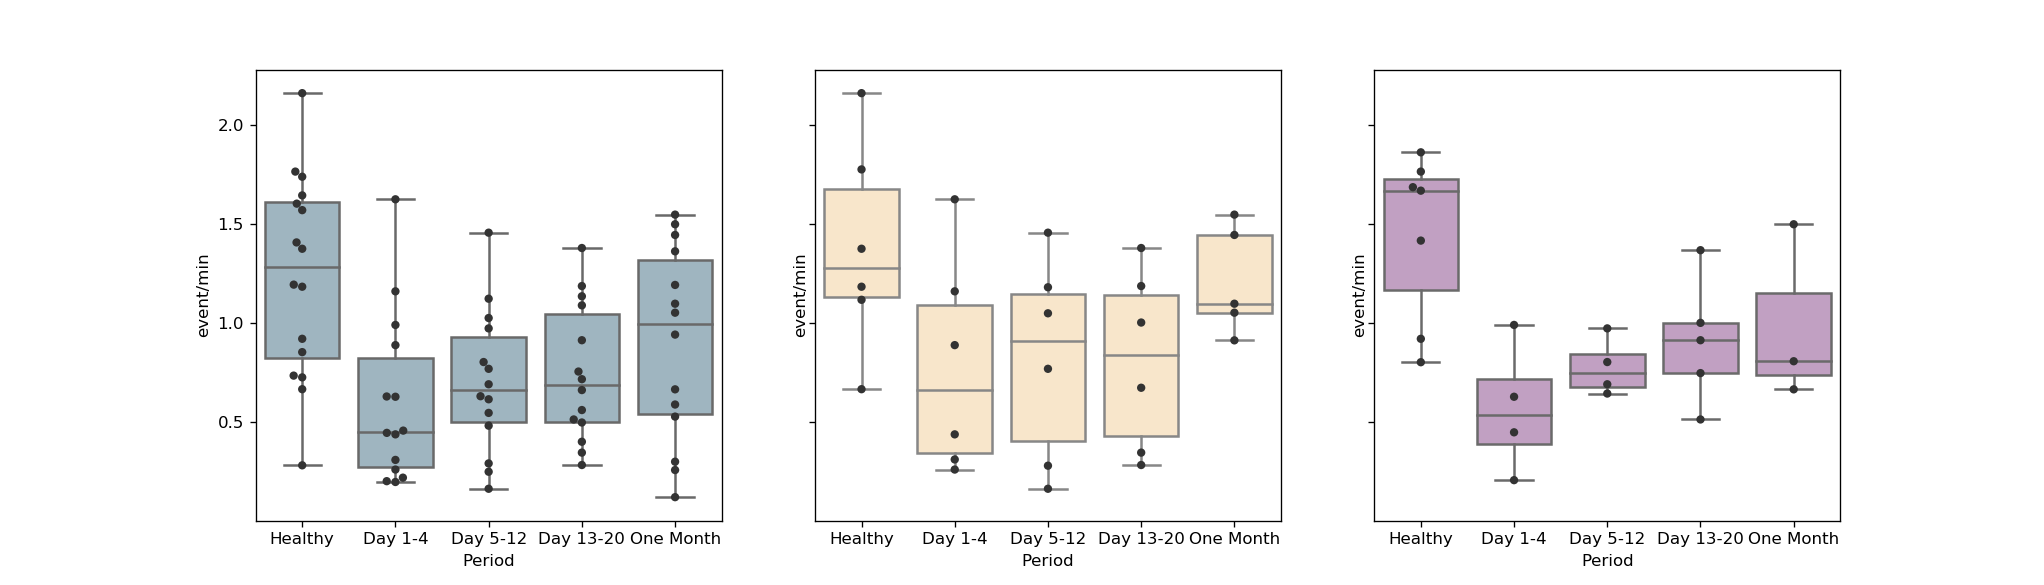

Healthy vs. Day 1-4
WilcoxonResult(statistic=4.0, pvalue=0.0023294396798343325)
WilcoxonResult(statistic=2.0, pvalue=0.07473549830588248)
WilcoxonResult(statistic=0.0, pvalue=0.06788915486182899)

Healthy vs. Day 5-12
WilcoxonResult(statistic=3.0, pvalue=0.001887179308509098)
WilcoxonResult(statistic=2.0, pvalue=0.07473549830588248)
WilcoxonResult(statistic=0.0, pvalue=0.06788915486182899)

Healthy vs. Day 13-20
WilcoxonResult(statistic=9.0, pvalue=0.006318521553682498)
WilcoxonResult(statistic=1.0, pvalue=0.046399461870904594)
WilcoxonResult(statistic=2.0, pvalue=0.13801073756865956)

Healthy vs. one month
WilcoxonResult(statistic=30.0, pvalue=0.15781136896845493)
WilcoxonResult(statistic=7.0, pvalue=0.892738400944348)
WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)



/home/dana_z/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [20]:
#print(df.columns)
dfM = df[(df.All>0)][['Mouse','Period','CellType','All']]
#dfM = dfM.merge(dfM.Dcc_.apply(lambda s: pd.Series({'All':s<0.05, 'Dcc_1':(s>=0.05)&(s<0.4),'Dcc_3':s>=0.9, 'Dcc_2':(s>=0.4)&(s<0.9)})), 
#    left_index=True, right_index=True)
dfM2 = dfM.groupby(['Mouse','Period','CellType'],as_index=False).mean()
df_long = pd.melt(dfM2,id_vars=['CellType','Period'], value_vars=['All'],value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
ind = 0
colors = ['#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
    g = sns.swarmplot(x="Period", y="event/min",data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
                      order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
                      ax=ax[ind],**{'label':'_nolegend_'})
    g = sns.boxplot(x="Period", y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                    order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
                    color=colors[ind],ax=ax[ind])
    ind = ind +1

# Shrink current axis by 20%
# box = g.get_position()
# g.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# # Put a legend to the right of the current axis
# g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/home/dana_z/ssd_2TB/6OHDA/figs/Paper_1/firingRate.svg',transparent=True )
#print(dfM2[~dfM2.Mouse.isin(['1231','1253'])].Mouse.unique(),dfM2[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='MSN')].Mouse.unique())
dfM2['stats'] = dfM2.apply(lambda row: row.All-float(dfM2.query("Period == 'Healthy' and Mouse == '"+str(row.Mouse)+"'and CellType == '"+str(row.CellType)+"'")['All']),axis=1)


print('Healthy vs. Day 1-4')
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='MSN')]))
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='PV')]))
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='CHI')]))
print('')

print('Healthy vs. Day 5-12')
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='MSN')]))
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='PV')]))
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='CHI')]))
print('')

print('Healthy vs. Day 13-20')
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='MSN')]))
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='PV')]))
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='CHI')]))
print('')

print('Healthy vs. one month')
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='One Month')&(dfM2.CellType=='MSN')]))
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='One Month')&(dfM2.CellType=='PV')]))
print(sci.stats.wilcoxon(dfM2.stats[(dfM2.Period=='One Month')&(dfM2.CellType=='CHI')]))
print('')


In [21]:
dfM2

,Mouse,Period,CellType,All,stats
0,0761,Day 1-4,CHI,0.448179,-0.471845
1,0761,Day 1-4,MSN,0.445387,-0.474637
2,0761,Day 13-20,CHI,1.367062,0.447037
3,0761,Day 13-20,MSN,1.134549,0.214525
4,0761,Day 5-12,CHI,0.643881,-0.276143
...,...,...,...,...,...
119,8815,Day 5-12,MSN,0.690560,-0.034856
120,8815,Healthy,CHI,0.801895,0.000000
121,8815,Healthy,MSN,0.725416,0.000000
122,8815,One Month,CHI,0.665001,-0.136894


<IPython.core.display.Javascript object>


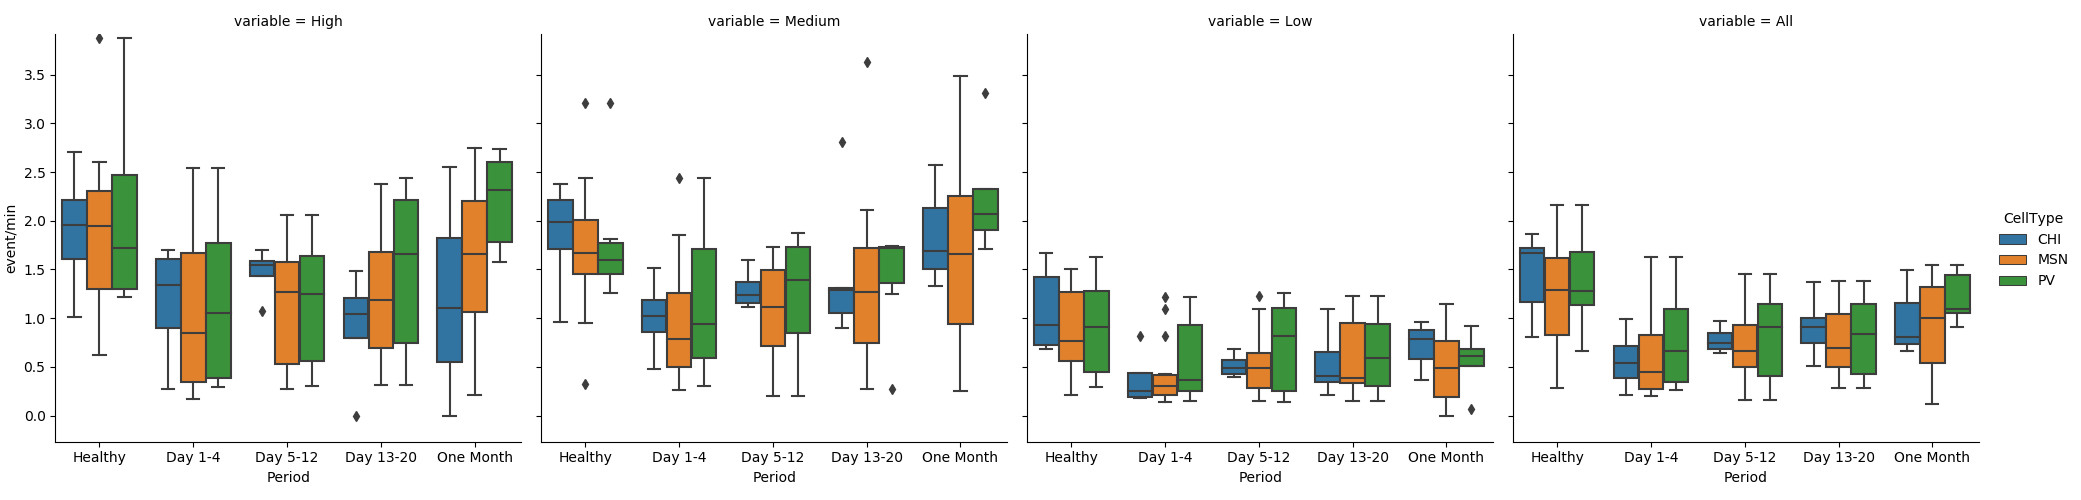

In [22]:
#print(df.columns)
dfM = df[(df.All>0)][['Mouse','Period','CellType','All','High','Medium','Low']]
#dfM = dfM.merge(dfM.Dcc_.apply(lambda s: pd.Series({'All':s<0.05, 'Dcc_1':(s>=0.05)&(s<0.4),'Dcc_3':s>=0.9, 'Dcc_2':(s>=0.4)&(s<0.9)})), 
#    left_index=True, right_index=True)
dfM2 = dfM.groupby(['Mouse','Period','CellType'],as_index=False).mean()
df_long = pd.melt(dfM2,id_vars=['CellType','Period'], value_vars=['High','Medium','Low','All'],value_name='event/min')
g = sns.catplot(x="Period", y="event/min",hue="CellType", col="variable" ,data=df_long, kind="box",order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'])


<IPython.core.display.Javascript object>


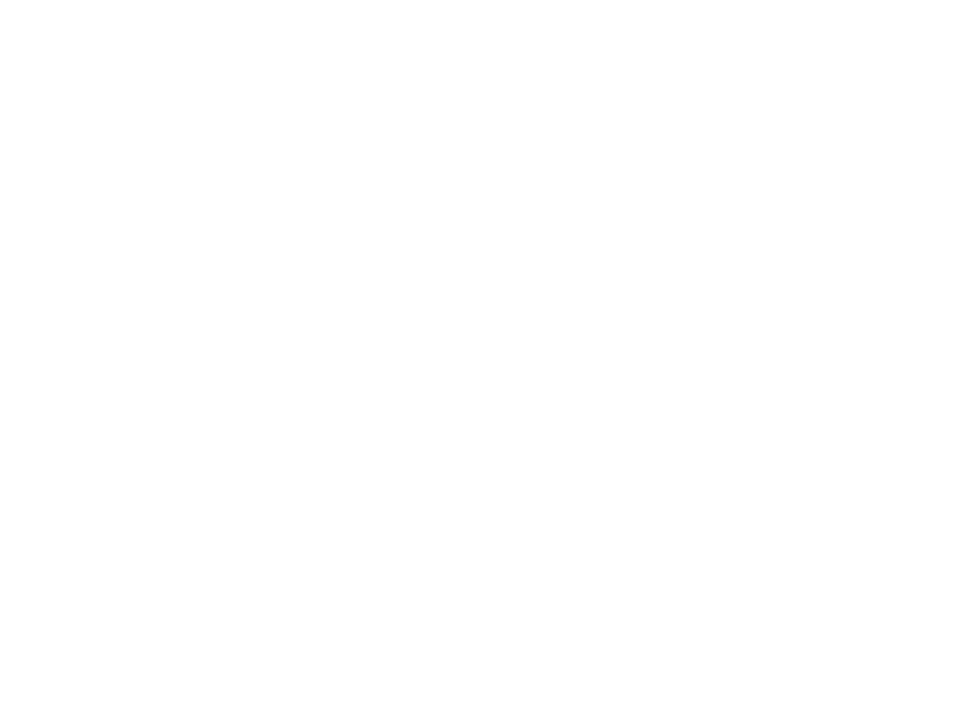

Healthy vs. Day 1-4
High
MannwhitneyuResult(statistic=60.0, pvalue=0.016141724793608578)
MannwhitneyuResult(statistic=10.0, pvalue=0.11488313523056903)
MannwhitneyuResult(statistic=5.0, pvalue=0.05409862376185072)
Medium
MannwhitneyuResult(statistic=44.0, pvalue=0.0025079404220825327)
MannwhitneyuResult(statistic=11.0, pvalue=0.1489765308040839)
MannwhitneyuResult(statistic=4.0, pvalue=0.03630046972497867)
Low
MannwhitneyuResult(statistic=41.0, pvalue=0.0016908667948350574)
MannwhitneyuResult(statistic=11.0, pvalue=0.1489765308040839)
MannwhitneyuResult(statistic=3.0, pvalue=0.023610452001788587)
Healthy vs. Day 5-12
High
MannwhitneyuResult(statistic=56.0, pvalue=0.010522797625614175)
MannwhitneyuResult(statistic=10.0, pvalue=0.11488313523056903)
MannwhitneyuResult(statistic=7.0, pvalue=0.10965132483965939)
Medium
MannwhitneyuResult(statistic=45.0, pvalue=0.002851016066216176)
MannwhitneyuResult(statistic=12.0, pvalue=0.18923879662233944)
MannwhitneyuResult(statistic=5.0, pvalue=0.0540

In [59]:
#print(df.columns)
dfM = df[(df.All>0)][['Mouse','Period','CellType','High','Low','Medium']]
dfM2 = dfM.groupby(['Mouse','Period','CellType'],as_index=False).mean()
df_long = pd.melt(dfM2,id_vars=['CellType','Period'], value_vars=['High','Low','Medium'],value_name='event/min')

# g = sns.catplot(x="Period", y="event/min",hue="CellType", col="variable" ,data=df_long, kind="box",order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
#                col_order = ['High','Medium','Low'])
for pt in ['High','Medium','Low']:
    g = sns.swarmplot(x="Period", y="event/min",hue="CellType",data=df_long[(df_long.variable == pt)],
                      color = [.2,.2,.2],dodge = True,
                      order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
                      hue_order=['MSN','PV','CHI'],**{'label':'_nolegend_'})
    g = sns.boxplot(x="Period", y="event/min",hue="CellType",data=df_long[(df_long.variable == pt)], dodge = True,
                    order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
                    hue_order=['MSN','PV','CHI'],palette=['#99B7C5','#FFE7C4','#C69AC8'])

    # Shrink current axis by 20%
    box = g.get_position()
    g.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('/home/dana_z/ssd_2TB/6OHDA/figs/Paper_1/firingRate_'+pt+'.svg',transparent=True )
    plt.clf()

#print(dfM2[~dfM2.Mouse.isin(['1231','1253'])].Mouse.unique(),dfM2[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='MSN')].Mouse.unique())

print('Healthy vs. Day 1-4')
print('High')
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.High[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.High[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.High[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='CHI')]))
print('Medium')
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.Medium[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.Medium[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.Medium[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='CHI')]))
print('Low')
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.Low[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.Low[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.Low[(dfM2.Period=='Day 1-4')&(dfM2.CellType=='CHI')]))

print('Healthy vs. Day 5-12')
print('High')
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.High[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.High[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.High[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='CHI')]))
print('Medium')
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.Medium[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.Medium[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.Medium[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='CHI')]))
print('Low')
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.Low[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.Low[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.Low[(dfM2.Period=='Day 5-12')&(dfM2.CellType=='CHI')]))

print('Healthy vs. Day 13-20')
print('High')
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.High[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.High[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.High[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='CHI')]))
print('Medium')
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.Medium[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.Medium[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.Medium[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='CHI')]))
print('Low')
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.Low[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.Low[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.Low[(dfM2.Period=='Day 13-20')&(dfM2.CellType=='CHI')]))

print('Healthy vs. one month')
print('High')
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.High[(dfM2.Period=='One Month')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.High[(dfM2.Period=='One Month')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.High[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.High[(dfM2.Period=='One Month')&(dfM2.CellType=='CHI')]))
print('Medium')
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.Medium[(dfM2.Period=='One Month')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.Medium[(dfM2.Period=='One Month')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.Medium[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.Medium[(dfM2.Period=='One Month')&(dfM2.CellType=='CHI')]))
print('Low')
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='MSN')],dfM2.Low[(dfM2.Period=='One Month')&(dfM2.CellType=='MSN')]))
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='PV')],dfM2.Low[(dfM2.Period=='One Month')&(dfM2.CellType=='PV')]))
print(sci.stats.mannwhitneyu(dfM2.Low[(dfM2.Period=='Healthy')&(dfM2.CellType=='CHI')],dfM2.Low[(dfM2.Period=='One Month')&(dfM2.CellType=='CHI')]))


<b>Recreate figure 2d and 2e </b> - flourescence aligned to mvmt onset and quantification
<h1> Redo --  Zscore for proper comparison , and divide by periods </h1>

In [7]:
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<5:
        return 'Day 1-4'
    elif day<13:
        return 'Day 5-12'
    elif day<21:
        return 'Two weeks'
    else:
        return 'One Month'

df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)
df['Beta'] = df.apply (lambda row: row.Mouse in betaMice , axis=1)

df['High'] =  df.apply (lambda row: row.high/row.numHigh if row.numHigh != 0 else row.high, axis=1)
df['Medium'] = df.apply (lambda row: row.med/row.numMed if row.numMed != 0 else row.med, axis=1)
df['Low'] = df.apply (lambda row: row.low/row.numLow if row.numLow != 0 else row.low, axis=1)
df['All'] = df.apply (lambda row: row.all_/row.numAll if row.numAll != 0 else row.all_, axis=1)


<IPython.core.display.Javascript object>


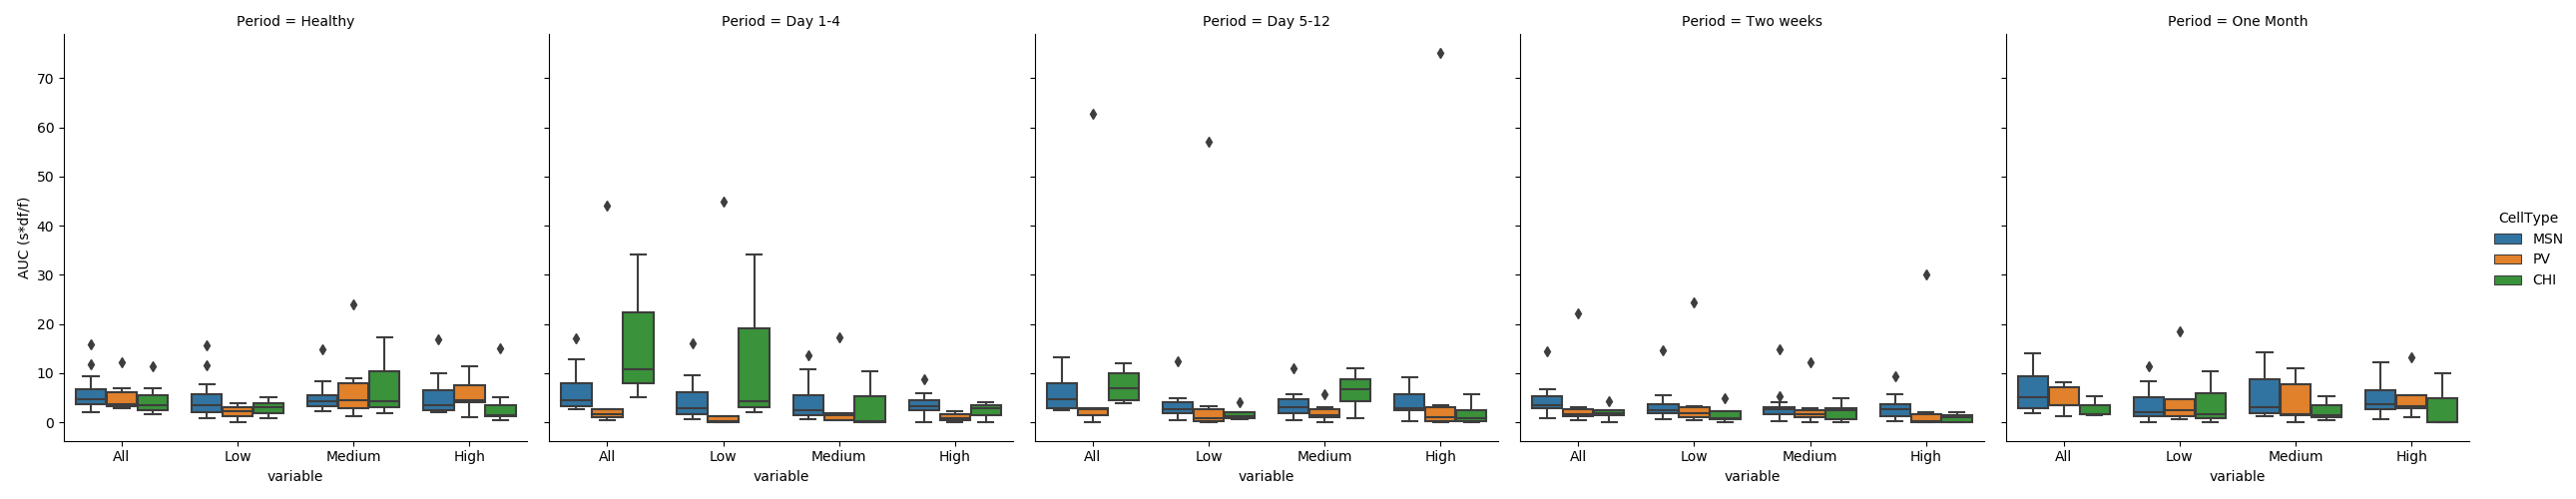

In [462]:
df_long = df[(df.All>0)].groupby(['Mouse','Period','CellType'],as_index=False).mean().melt(id_vars=['CellType','Period'], value_vars=['All','Low','Medium','High'],value_name='AUC (s*df/f)')
g = sns.catplot(x="variable", y="AUC (s*df/f)",hue="CellType", col="Period",data=df_long, kind="box",
                col_order=['Healthy', 'Day 1-4', 'Day 5-12', 'Two weeks', 'One Month'],hue_order=['MSN','PV','CHI']);

<IPython.core.display.Javascript object>


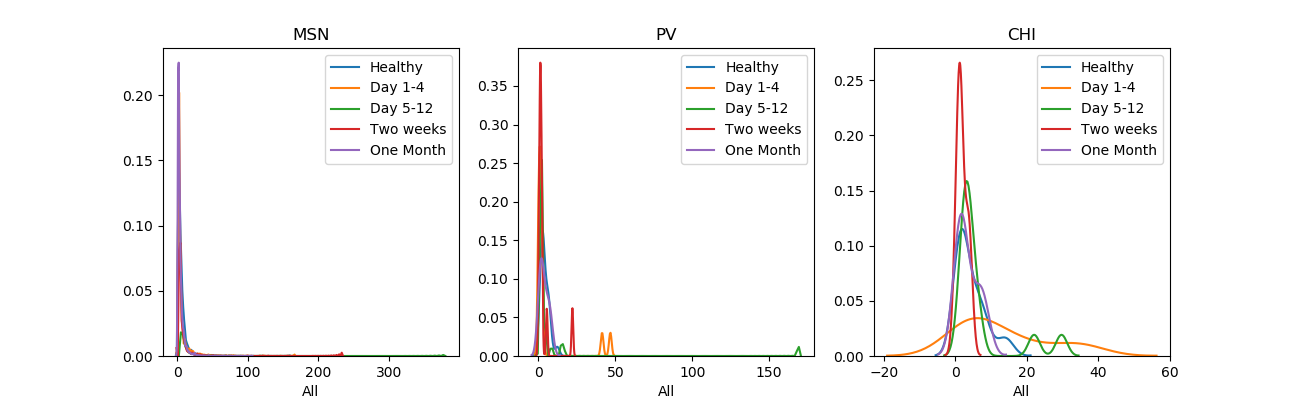

/home/dana_z/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'CHI')

In [464]:
fig, ax = plt.subplots(1,3,figsize=(13, 4))
for par in list(df.Period.unique()):
    sns.distplot(df.All[(df.All>0)&(df.Period==par)&(df.CellType == 'MSN')],hist=False ,label=par,ax=ax[0])
    sns.distplot(df.All[(df.All>0)&(df.Period==par)&(df.CellType == 'PV')],hist=False ,label=par,ax=ax[1])
    sns.distplot(df.All[(df.All>0)&(df.Period==par)&(df.CellType == 'CHI')],hist=False ,label=par,ax=ax[2])#,kde_kws = {'cumulative':True}

ax[0].set_title('MSN')
ax[1].set_title('PV')
ax[2].set_title('CHI')

In [17]:
for par in list(df.Period.unique()):
    print(par,': ',len(df[(df.CellType=='CHI')&(df.Period==par)]))
# g = sns.PairGrid(df[(df.All>0)], hue="CellType",y_vars=["All", "numAll"],x_vars=['CellType','Period'])
# g.map(plt.scatter, s=50, edgecolor="white")
# g.add_legend();

Healthy :  30
Day 1-4 :  8
Day 5-12 :  25
Two weeks :  18
One Month :  8


<b> repeat figure 4 d-f </b> - correleation between neurons

In [8]:
import timeit, functools

def circShiftRoll(shifts,data):
    return  np.array([np.roll(row, x) for row,x in zip(data, shifts)])

#              SLOWER!!
def circShiftAdvIndex(shifts,data):
    rows, column_indices = np.ogrid[:data.shape[0], :data.shape[1]]

    shifts[shifts < 0] += data.shape[1]
    column_indices = column_indices - shifts[:, np.newaxis]

    return data[rows, column_indices]

def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<5:
        return 'Day 1-4'
    elif day<13:
        return 'Day 5-12'
    elif day<21:
        return 'Day 13-20'
    else:
        return 'One Month'

#Ca = getOnsetOrPeriod('1208','1208_BaselineA','Pre','caOnset_Hf')
#shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])

# %timeit circShiftRoll(shifts,Ca)
# > 9.12 ms ± 41.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# %timeit circShiftAdvIndex(shifts,Ca)
# > 13 ms ± 58.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [ ]:
col_names = ['Mouse','Sess','Day','numred','MSN-MSN','MSN-PV','MSN-CHI','PV-PV','CHI-CHI','s_MSN-MSN','s_MSN-PV','s_MSN-CHI','s_PV-PV','s_CHI-CHI']
df = pd.DataFrame(columns = col_names)
cond = ['MSNdataH','MSNdataP']
numshifts = 1000
for c in cond:
    data = eval('Hf'+c)
    for sess in data.keys():
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            m = sess[0:4]
            cre = getCreType(Files[1],m)
            numRed = data[sess]['trace']['numred']
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')            
            cor = np.corrcoef(Ca)
            cor[np.arange(cor.shape[0])[:,None] < np.arange(cor.shape[1])+1] = np.nan
            if numRed == 0:
                # Only MSNs
                df2 = pd.DataFrame([{'Mouse':m,'Sess':sess,'Day':day,'numred':numRed,'MSN-MSN':np.nanmean(cor)}])
                Ms = []
                for s in range(0,numshifts):
                    shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                    Ca2 = circShiftRoll(shifts,Ca)
                    cor = np.corrcoef(Ca2)
                    cor[np.arange(cor.shape[0])[:,None] < np.arange(cor.shape[1])+1] = np.nan
                    Ms.append(np.nanmean(cor))
                df2['s_MSN-MSN'] = Ms
            else:
                df2 = pd.DataFrame([{'Mouse':m,'Sess':sess,'Day':day,'numred':numRed,'MSN-MSN':np.nanmean(cor[numRed:,numRed:])}])
                msnCre = 'MSN-'+cre
                creCre = cre + '-' +cre
                if cre != 'NA':
                    df2[msnCre] = np.nanmean(cor[numRed:,:numRed])
                    df2[creCre] = np.nanmean(cor[:numRed,:numRed])                   
                MM = []
                MC = []
                CC = []
                for s in range(0,numshifts):
                    shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                    Ca2 = circShiftRoll(shifts,Ca)
                    cor = np.corrcoef(Ca2)
                    cor[np.arange(cor.shape[0])[:,None] < np.arange(cor.shape[1])+1] = np.nan
                    MM.append(np.nanmean(cor[numRed:,numRed:]))
                    MC.append(np.nanmean(cor[numRed:,:numRed]))
                    CC.append(np.nanmean(cor[:numRed,:numRed]))
                df2['s_MSN-MSN'] = [MM]
                if cre != 'NA':
                    df2['s_'+msnCre] = [MC]
                    df2['s_'+creCre] = [CC]
            df = pd.concat([df,df2],sort=True)
        except:
            print(sess)

In [19]:
f.close


df = pd.read_hdf('corrsAndShuffles.h5','df')


# look at Co-occorance when CHI/PV is on

In [ ]:
col_names = ['Mouse','Sess','Day','Period','numred','MSN-MSN','MSN-PV','MSN-CHI','PV-PV','CHI-CHI','s_MSN-MSN','s_MSN-PV','s_MSN-CHI','s_PV-PV','s_CHI-CHI']
df_creOn = pd.DataFrame(columns = col_names)
df_creOff = pd.DataFrame(columns = col_names)
cond = ['MSNdataH','MSNdataP']
numshifts = 1000
for c in cond:
    data = eval('Hf'+c)
    for sess in data.keys():
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            m = sess[0:4]
            cre = getCreType(Files[1],m)
            numRed = data[sess]['trace']['numred']
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
            if numRed == 0:
                continue
            else:
                Ca_on = Ca[:,(np.sum(Ca[:numRed,:],axis=0)>0)]
                Ca_off = Ca[:,np.sum(Ca[:numRed,:],axis=0)==0]
                cor_on = np.corrcoef(Ca_on)
                cor_off = np.corrcoef(Ca_off)
                cor_on[np.arange(cor_on.shape[0])[:,None] < np.arange(cor_on.shape[1])+1] = np.nan
                cor_off[np.arange(cor_off.shape[0])[:,None] < np.arange(cor_off.shape[1])+1] = np.nan

                df2_on = pd.DataFrame([{'Mouse':m,'Sess':sess,'Day':day,'numred':numRed,'MSN-MSN':np.nanmean(cor_on[numRed:,numRed:])}])
                df2_off = pd.DataFrame([{'Mouse':m,'Sess':sess,'Day':day,'numred':numRed,'MSN-MSN':np.nanmean(cor_off[numRed:,numRed:])}])

                msnCre = 'MSN-'+cre
                creCre = cre + '-' +cre
                if cre != 'NA':
                    df2_on[msnCre] = np.nanmean(cor_on[numRed:,:numRed])
                    df2_on[creCre] = np.nanmean(cor_on[:numRed,:numRed])                   
                MM_on = []
                MM_off = []
                MC = []
                CC = []
                for s in range(0,numshifts):
                    shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                    Ca2 = circShiftRoll(shifts,Ca)
                    
                    Ca_on = Ca2[:,(np.sum(Ca2[:numRed,:],axis=0)>0)]
                    Ca_off = Ca2[:,np.sum(Ca2[:numRed,:],axis=0)==0]
                    cor_on = np.corrcoef(Ca_on)
                    cor_off = np.corrcoef(Ca_off)
                    cor_on[np.arange(cor_on.shape[0])[:,None] < np.arange(cor_on.shape[1])+1] = np.nan
                    cor_off[np.arange(cor_off.shape[0])[:,None] < np.arange(cor_off.shape[1])+1] = np.nan

                    MM_on.append(np.nanmean(cor_on[numRed:,numRed:]))
                    MM_off.append(np.nanmean(cor_off[numRed:,numRed:]))
                    MC.append(np.nanmean(cor_on[numRed:,:numRed]))
                    CC.append(np.nanmean(cor_on[:numRed,:numRed]))
                df2_on['s_MSN-MSN'] = [MM_on]
                df2_off['s_MSN-MSN'] = [MM_off]
                if cre != 'NA':
                    df2_on['s_'+msnCre] = [MC]
                    df2_on['s_'+creCre] = [CC]
            df_creOn = pd.concat([df_creOn,df2_on],sort=True)
            df_creOff = pd.concat([df_creOff,df2_off],sort=True)
        except:
            print(sess)
df_creOn.to_hdf('corrsAndShuffles','df_creOn')
df_creOff.to_hdf('corrsAndShuffles','df_creOff')

In [71]:
df =  pd.read_hdf('corrsAndShuffles.h5','df')
df_creOn = pd.read_hdf('corrsAndShuffles','df_creOn')
df_creOff = pd.read_hdf('corrsAndShuffles','df_creOff')

df['Period'] = df.apply(lambda row: periodCalc(row.Day), axis=1)
df['cre'] = df.apply(lambda row: getCreType(Files[1],row.Mouse), axis=1)
df_creOn['cre'] = df_creOn.apply(lambda row: getCreType(Files[1],row.Mouse), axis=1)

# intialize the data sets
df_MSN_MSN = df[['Mouse','Sess','Day','Period','numred','cre']]
df_MSN_CRE = df[['Mouse','Sess','Day','Period','numred','cre']]
df_CRE_CRE = df[['Mouse','Sess','Day','Period','numred','cre']]



In [63]:
df_creOn.columns

Index(['CHI-CHI', 'Day', 'MSN-CHI', 'MSN-MSN', 'MSN-PV', 'Mouse', 'PV-PV',
       'Period', 'Sess', 'numred', 's_CHI-CHI', 's_MSN-CHI', 's_MSN-MSN',
       's_MSN-PV', 's_PV-PV'],
      dtype='object')

In [72]:
# calc mean and std for each shuffle:
df_MSN_MSN = df_MSN_MSN.merge(df.apply(lambda row: pd.Series({'sAll':np.nanmean(row['s_MSN-MSN']),
                                                              'sAll_std':np.nanstd(row['s_MSN-MSN']),
                                                              'All':row['MSN-MSN'],
                                                              'Sess':row.Sess}),axis=1),
                              left_on='Sess', right_on='Sess')
df_MSN_CRE = df_MSN_CRE.merge(df[(df.cre!='NA')].apply(lambda row: pd.Series({'sAll':np.nanmean(row['s_'+'MSN-'+row.cre]),
                                                              'sAll_std':np.nanstd(row['s_'+'MSN-'+row.cre]),
                                                              'All':row['MSN-'+row.cre],
                                                              'Sess':row.Sess}),axis=1),
                              left_on='Sess', right_on='Sess')

df_CRE_CRE = df_CRE_CRE.merge(df[(df.cre!='NA')].apply(lambda row: pd.Series({'sAll':np.nanmean(row['s_'+row.cre+'-'+row.cre]),
                                                              'sAll_std':np.nanstd(row['s_'+row.cre+'-'+row.cre]),
                                                              'All':row[row.cre+'-'+row.cre],
                                                              'Sess':row.Sess}) ,axis=1),
                              left_on='Sess', right_on='Sess')

df_MSN_MSN = df_MSN_MSN.merge(df_creOn.apply(lambda row: pd.Series({'sOn':np.nanmean(row['s_MSN-MSN']),
                                                              'sOn_std':np.nanstd(row['s_MSN-MSN']),
                                                              'On':row['MSN-MSN'],
                                                              'Sess':row.Sess}),axis=1),
                              left_on='Sess', right_on='Sess')
df_MSN_CRE = df_MSN_CRE.merge(df_creOn[(df_creOn.cre!='NA')].apply(lambda row: pd.Series({'sOn':np.nanmean(row['s_'+'MSN-'+row.cre]),
                                                              'sOn_std':np.nanstd(row['s_'+'MSN-'+row.cre]),
                                                              'On':row['MSN-'+row.cre],
                                                              'Sess':row.Sess}),axis=1),
                              left_on='Sess', right_on='Sess')

df_CRE_CRE = df_CRE_CRE.merge(df_creOn[(df_creOn.cre!='NA')].apply(lambda row: pd.Series({'sOn':np.nanmean(row['s_'+row.cre+'-'+row.cre]),
                                                              'sOn_std':np.nanstd(row['s_'+row.cre+'-'+row.cre]),
                                                              'On':row[row.cre+'-'+row.cre],
                                                              'Sess':row.Sess}) ,axis=1),
                              left_on='Sess', right_on='Sess')

df_MSN_MSN = df_MSN_MSN.merge(df_creOff.apply(lambda row: pd.Series({'sOff':np.nanmean(row['s_MSN-MSN']),
                                                              'sOff_std':np.nanstd(row['s_MSN-MSN']),
                                                              'Off':row['MSN-MSN'],
                                                              'Sess':row.Sess}),axis=1),
                              left_on='Sess', right_on='Sess')


/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


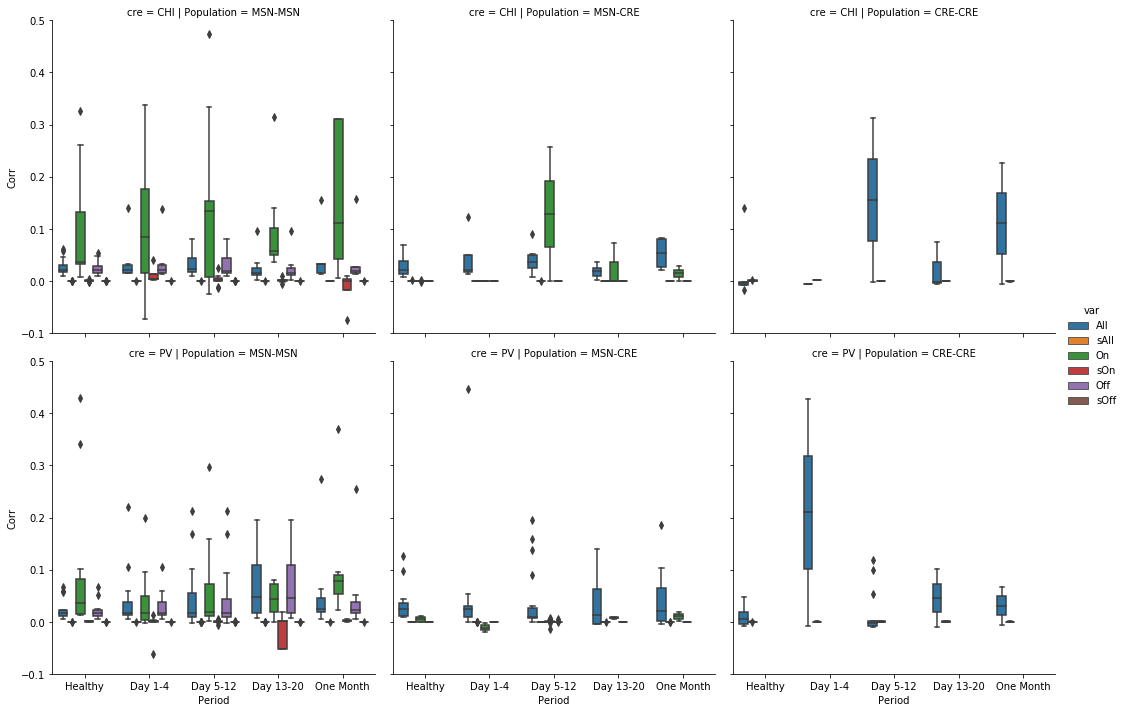

In [106]:
MSN_melt = df_MSN_MSN.melt(id_vars=['Period','Mouse','cre'], value_vars=['All','sAll','On','sOn','Off','sOff'],
                           var_name='var', value_name='Corr')
MSN_melt['Population'] = 'MSN-MSN'
MSNc_melt = df_MSN_CRE.melt(id_vars=['Period','Mouse','cre'], value_vars=['All','sAll','On','sOn'],
                           var_name='var', value_name='Corr')
MSNc_melt['Population'] = 'MSN-CRE'
Cre_melt = df_CRE_CRE.melt(id_vars=['Period','Mouse','cre'], value_vars=['All','sAll','On','sOn'],
                           var_name='var', value_name='Corr')
Cre_melt ['Population'] = 'CRE-CRE'

df_melt = MSN_melt.append([MSNc_melt,Cre_melt])
g = sns.catplot(x="Period", y="Corr", hue="var",col='Population',row='cre', data=df_melt,kind="box", order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'])
g.axes[0,0].set_ylim([-.1,.50])
g.savefig('/home/dana_z/ssd_2TB/6OHDA/figs/XueMeeting_Jan17/Co-occurance.png')

In [96]:
%matplotlib inline
for m in df_melt.Mouse.unique():
    g = sns.catplot(x="Period", y="Corr", hue="var",
                    data=MSN_melt[(MSN_melt.Mouse==m)],#col='Population',
                    kind="box", order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'])
    g.fig.suptitle(m)
    g.savefig('/home/dana_z/ssd_2TB/6OHDA/figs/XueMeeting_Jan17/'+m+'_CoOccorence.png')
    plt.close()


In [109]:
df_MSN_MSN[(df_MSN_MSN.cre=='CHI')&(df_MSN_MSN.Period.isin(['Day 1-4','Day 13-20', 'One Month']))].groupby(['Period','Mouse']).count()

Sess  Day  numred  cre  sAll  sAll_std  All  sOn  sOn_std  \
Period    Mouse                                                              
Day 1-4   0761      1    1       1    1     1         1    1    0        0   
          1208      2    2       2    2     2         2    2    2        2   
          1793      2    2       2    2     2         2    2    1        1   
          8815      1    1       1    1     1         1    1    1        1   
Day 13-20 0761      1    1       1    1     1         1    1    1        1   
          1208      3    3       3    3     3         3    3    1        1   
          1222      1    1       1    1     1         1    1    1        1   
          1793      2    2       2    2     2         2    2    2        2   
          8815      3    3       3    3     3         3    3    2        2   
One Month 0761      1    1       1    1     1         1    1    1        1   
          1208      2    2       2    2     2         2    2    2        2   
          8815      2    2       2    2     2         2    2    1        1   

                 On  sOff  sOff_std  Off  
Period    Mouse                           
Day 1-4   0761    0     1         1    1  
          1208    2     2         2    2  
          1793    1     2         2    2  
          8815    1     1         1    1  
Day 13-20 0761    1     1         1    1  
          1208    1     3         3    3  
          1222    1     1         1    1  
          1793    2     2         2    2  
          8815    2     3         3    3  
One Month 0761    1     1         1    1  
          1208    2     2         2    2  
          8815    1     2         2    2